<a href="https://colab.research.google.com/github/MISJasonChuang/ELM_Pretest/blob/main/ELM_randomness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  --quiet hide code cell output
!pip install -U scikit-multiflow --quiet
!pip install statsmodels --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.6/450.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# -*- coding: utf8
# Author: David C. Lambert [dcl -at- panix -dot- com]
# Copyright(c) 2013
# License: Simple BSD

"""The :mod:`random_layer` module
implements Random Layer transformers.

Random layers are arrays of hidden unit activations that are
random functions of input activation values (dot products for simple
activation functions, distances from prototypes for radial basis
functions).

They are used in the implementation of Extreme Learning Machines (ELMs),
but can be used as a general input mapping.
"""

from abc import ABCMeta, abstractmethod

from math import sqrt

import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import cdist, pdist, squareform

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.base import BaseEstimator, TransformerMixin

__all__ = [
    "RandomLayer",
    "MLPRandomLayer",
    "RBFRandomLayer",
    "GRBFRandomLayer",
]


class BaseRandomLayer(BaseEstimator, TransformerMixin):
    """Abstract Base Class for random  layers"""

    __metaclass__ = ABCMeta

    _internal_activation_funcs = dict()

    @classmethod
    def activation_func_names(cls):
        """Get list of internal activation function names"""
        return cls._internal_activation_funcs.keys()

    # take n_hidden and random_state, init components_ and
    # input_activations_
    def __init__(
        self, n_hidden=20, random_state=0, activation_func=None, activation_args=None
    ):
        self.n_hidden = n_hidden
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args

        self.components_ = dict()
        self.input_activations_ = None

        # keyword args for internally defined funcs
        self._extra_args = dict()

    @abstractmethod
    def _generate_components(self, X):
        """Generate components of hidden layer given X"""

    @abstractmethod
    def _compute_input_activations(self, X):
        """Compute input activations given X"""

    # compute input activations and pass them
    # through the hidden layer transfer functions
    # to compute the transform
    def _compute_hidden_activations(self, X):
        """Compute hidden activations given X"""

        self._compute_input_activations(X)

        acts = self.input_activations_

        if callable(self.activation_func):
            args_dict = self.activation_args if (self.activation_args) else {}
            X_new = self.activation_func(acts, **args_dict)
        else:
            func_name = self.activation_func
            func = self._internal_activation_funcs[func_name]

            X_new = func(acts, **self._extra_args)

        return X_new

    # perform fit by generating random components based
    # on the input array
    def fit(self, X, y=None):
        """Generate a random hidden layer.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training set: only the shape is used to generate random component
            values for hidden units

        y : is not used: placeholder to allow for usage in a Pipeline.

        Returns
        -------
        self
        """
        X = check_array(X)

        self._generate_components(X)

        return self

    # perform transformation by calling compute_hidden_activations
    # (which will normally call compute_input_activations first)
    def transform(self, X, y=None):
        """Generate the random hidden layer's activations given X as input.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape [n_samples, n_features]
            Data to transform

        y : is not used: placeholder to allow for usage in a Pipeline.

        Returns
        -------
        X_new : numpy array of shape [n_samples, n_components]
        """
        X = check_array(X)

        if self.components_ is None:
            raise ValueError("No components initialized")

        return self._compute_hidden_activations(X)


class RandomLayer(BaseRandomLayer):
    """RandomLayer is a transformer that creates a feature mapping of the
    inputs that corresponds to a layer of hidden units with randomly
    generated components.

    The transformed values are a specified function of input activations
    that are a weighted combination of dot product (multilayer perceptron)
    and distance (rbf) activations:

      input_activation = alpha * mlp_activation + (1-alpha) * rbf_activation

      mlp_activation(x) = dot(x, weights) + bias
      rbf_activation(x) = rbf_width * ||x - center||/radius

      alpha and rbf_width are specified by the user

      weights and biases are taken from normal distribution of
      mean 0 and sd of 1

      centers are taken uniformly from the bounding hyperrectangle
      of the inputs, and radii are max(||x-c||)/sqrt(n_centers*2)

    The input activation is transformed by a transfer function that defaults
    to numpy.tanh if not specified, but can be any callable that returns an
    array of the same shape as its argument (the input activation array, of
    shape [n_samples, n_hidden]).  Functions provided are 'sine', 'tanh',
    'tribas', 'inv_tribas', 'sigmoid', 'hardlim', 'softlim', 'gaussian',
    'multiquadric', or 'inv_multiquadric'.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate

    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation

    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation

    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that woud otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_features, n_hidden]

    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribas',
        'sigmoid', 'hardlim', 'softlim', 'gaussian', 'multiquadric',
        'inv_multiquadric' or a callable.  If None is given, 'tanh'
        will be used.

        If a callable is given, it will be used to compute the activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `input_activations_` : numpy array of shape [n_samples, n_hidden]
        Array containing dot(x, hidden_weights) + bias for all samples

    `components_` : dictionary containing two keys:
        `bias_weights_`   : numpy array of shape [n_hidden]
        `hidden_weights_` : numpy array of shape [n_features, n_hidden]

    See Also
    --------
    """

    # triangular activation function
    _tribas = lambda x: np.clip(1.0 - np.fabs(x), 0.0, 1.0)

    # inverse triangular activation function
    _inv_tribas = lambda x: np.clip(np.fabs(x), 0.0, 1.0)

    # sigmoid activation function
    _sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))

    # hard limit activation function
    _hardlim = lambda x: np.array(x > 0.0, dtype=float)

    _softlim = lambda x: np.clip(x, 0.0, 1.0)

    # gaussian RBF
    _gaussian = lambda x: np.exp(-pow(x, 2.0))

    # multiquadric RBF
    _multiquadric = lambda x: np.sqrt(1.0 + pow(x, 2.0))

    # inverse multiquadric RBF
    _inv_multiquadric = lambda x: 1.0 / (np.sqrt(1.0 + pow(x, 2.0)))

    # internal activation function table
    _internal_activation_funcs = {
        "sine": np.sin,
        "tanh": np.tanh,
        "tribas": _tribas,
        "inv_tribas": _inv_tribas,
        "sigmoid": _sigmoid,
        "softlim": _softlim,
        "hardlim": _hardlim,
        "gaussian": _gaussian,
        "multiquadric": _multiquadric,
        "inv_multiquadric": _inv_multiquadric,
    }

    def __init__(
        self,
        n_hidden=20,
        alpha=0.5,
        random_state=None,
        activation_func="tanh",
        activation_args=None,
        user_components=None,
        rbf_width=1.0,
    ):
        super(RandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args,
        )

        if isinstance(self.activation_func, str):
            func_names = self._internal_activation_funcs.keys()
            if self.activation_func not in func_names:
                msg = "unknown activation function '%s'" % self.activation_func
                raise ValueError(msg)

        self.alpha = alpha
        self.rbf_width = rbf_width
        self.user_components = user_components

        self._use_mlp_input = self.alpha != 0.0
        self._use_rbf_input = self.alpha != 1.0

    def _get_user_components(self, key):
        """Look for given user component"""
        try:
            return self.user_components[key]
        except (TypeError, KeyError):
            return None

    def _compute_radii(self):
        """Generate RBF radii"""

        # use supplied radii if present
        radii = self._get_user_components("radii")

        # compute radii
        if radii is None:
            centers = self.components_["centers"]

            n_centers = centers.shape[0]
            max_dist = np.max(pairwise_distances(centers))
            radii = np.ones(n_centers) * max_dist / sqrt(2.0 * n_centers)

        self.components_["radii"] = radii

    def _compute_centers(self, X, sparse, rs):
        """Generate RBF centers"""

        # use supplied centers if present
        centers = self._get_user_components("centers")

        # use points taken uniformly from the bounding
        # hyperrectangle
        if centers is None:
            n_features = X.shape[1]

            if sparse:
                fxr = xrange(n_features)
                cols = [X.getcol(i) for i in fxr]

                min_dtype = X.dtype.type(1.0e10)
                sp_min = lambda col: np.minimum(min_dtype, np.min(col.data))
                min_Xs = np.array(map(sp_min, cols))

                max_dtype = X.dtype.type(-1.0e10)
                sp_max = lambda col: np.maximum(max_dtype, np.max(col.data))
                max_Xs = np.array(map(sp_max, cols))
            else:
                min_Xs = X.min(axis=0)
                max_Xs = X.max(axis=0)

            spans = max_Xs - min_Xs
            ctrs_size = (self.n_hidden, n_features)
            centers = min_Xs + spans * rs.uniform(0.0, 1.0, ctrs_size)

        self.components_["centers"] = centers

    def _compute_biases(self, rs):
        """Generate MLP biases"""

        # use supplied biases if present
        biases = self._get_user_components("biases")
        if biases is None:
            b_size = self.n_hidden
            biases = rs.normal(size=b_size)

        self.components_["biases"] = biases

    def _compute_weights(self, X, rs):
        """Generate MLP weights"""

        # use supplied weights if present
        weights = self._get_user_components("weights")
        if weights is None:
            n_features = X.shape[1]
            hw_size = (n_features, self.n_hidden)
            weights = rs.normal(size=hw_size)

        self.components_["weights"] = weights

    def _generate_components(self, X):
        """Generate components of hidden layer given X"""

        rs = check_random_state(self.random_state)
        if self._use_mlp_input:
            self._compute_biases(rs)
            self._compute_weights(X, rs)

        if self._use_rbf_input:
            self._compute_centers(X, sp.issparse(X), rs)
            self._compute_radii()

    def _compute_input_activations(self, X):
        """Compute input activations given X"""

        n_samples = X.shape[0]

        mlp_acts = np.zeros((n_samples, self.n_hidden))
        if self._use_mlp_input:
            b = self.components_["biases"]
            w = self.components_["weights"]
            mlp_acts = self.alpha * (safe_sparse_dot(X, w) + b)

        rbf_acts = np.zeros((n_samples, self.n_hidden))
        if self._use_rbf_input:
            radii = self.components_["radii"]
            centers = self.components_["centers"]
            scale = self.rbf_width * (1.0 - self.alpha)
            rbf_acts = scale * cdist(X, centers) / radii

        self.input_activations_ = mlp_acts + rbf_acts


class MLPRandomLayer(RandomLayer):
    """Wrapper for RandomLayer with alpha (mixing coefficient) set
    to 1.0 for MLP activations only"""

    def __init__(
        self,
        n_hidden=20,
        random_state=None,
        activation_func="tanh",
        activation_args=None,
        weights=None,
        biases=None,
    ):
        user_components = {"weights": weights, "biases": biases}
        super(MLPRandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args,
            user_components=user_components,
            alpha=1.0,
        )


class RBFRandomLayer(RandomLayer):
    """Wrapper for RandomLayer with alpha (mixing coefficient) set
    to 0.0 for RBF activations only"""

    def __init__(
        self,
        n_hidden=20,
        random_state=None,
        activation_func="gaussian",
        activation_args=None,
        centers=None,
        radii=None,
        rbf_width=1.0,
    ):
        user_components = {"centers": centers, "radii": radii}
        super(RBFRandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args,
            user_components=user_components,
            rbf_width=rbf_width,
            alpha=0.0,
        )


class GRBFRandomLayer(RBFRandomLayer):
    """Random Generalized RBF Hidden Layer transformer

    Creates a layer of radial basis function units where:

       f(a), s.t. a = ||x-c||/r

    with c the unit center
    and f() is exp(-gamma * a^tau) where tau and r are computed
    based on [1]

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate, ignored if centers are provided

    `grbf_lambda` : float, optional (default=0.05)
        GRBF shape parameter

    `gamma` : {int, float} optional (default=1.0)
        Width multiplier for GRBF distance argument

    `centers` : array of shape (n_hidden, n_features), optional (default=None)
        If provided, overrides internal computation of the centers

    `radii` : array of shape (n_hidden),  optional (default=None)
        If provided, overrides internal computation of the radii

    `use_exemplars` : bool, optional (default=False)
        If True, uses random examples from the input to determine the RBF
        centers, ignored if centers are provided

    `random_state`  : int or RandomState instance, optional (default=None)
        Control the pseudo random number generator used to generate the
        centers at fit time, ignored if centers are provided

    Attributes
    ----------
    `components_` : dictionary containing two keys:
        `radii_`   : numpy array of shape [n_hidden]
        `centers_` : numpy array of shape [n_hidden, n_features]

    `input_activations_` : numpy array of shape [n_samples, n_hidden]
        Array containing ||x-c||/r for all samples

    See Also
    --------
    ELMRegressor, ELMClassifier, SimpleELMRegressor, SimpleELMClassifier,
    SimpleRandomLayer

    References
    ----------
    .. [1] Fernandez-Navarro, et al, "MELM-GRBF: a modified version of the
              extreme learning machine for generalized radial basis function
              neural networks", Neurocomputing 74 (2011), 2502-2510

    """

    # def _grbf(acts, taus):
    #     """GRBF activation function"""

    #     return np.exp(np.exp(-pow(acts, taus)))

    _grbf = lambda acts, taus: np.exp(np.exp(-pow(acts, taus)))

    _internal_activation_funcs = {"grbf": _grbf}

    def __init__(
        self,
        n_hidden=20,
        grbf_lambda=0.001,
        centers=None,
        radii=None,
        random_state=None,
    ):
        super(GRBFRandomLayer, self).__init__(
            n_hidden=n_hidden,
            activation_func="grbf",
            centers=centers,
            radii=radii,
            random_state=random_state,
        )

        self.grbf_lambda = grbf_lambda
        self.dN_vals = None
        self.dF_vals = None
        self.tau_vals = None

    # get centers from superclass, then calculate tau_vals
    # according to ref [1]
    def _compute_centers(self, X, sparse, rs):
        """Generate centers, then compute tau, dF and dN vals"""

        super(GRBFRandomLayer, self)._compute_centers(X, sparse, rs)

        centers = self.components_["centers"]
        sorted_distances = np.sort(squareform(pdist(centers)))
        self.dF_vals = sorted_distances[:, -1]
        self.dN_vals = sorted_distances[:, 1] / 100.0
        # self.dN_vals = 0.0002 * np.ones(self.dF_vals.shape)

        tauNum = np.log(np.log(self.grbf_lambda) / np.log(1.0 - self.grbf_lambda))

        tauDenom = np.log(self.dF_vals / self.dN_vals)

        self.tau_vals = tauNum / tauDenom

        self._extra_args["taus"] = self.tau_vals

    # get radii according to ref [1]
    def _compute_radii(self):
        """Generate radii"""

        denom = pow(-np.log(self.grbf_lambda), 1.0 / self.tau_vals)
        self.components_["radii"] = self.dF_vals / denom

In [3]:
%%capture
# -*- coding: utf8
# Author: David C. Lambert [dcl -at- panix -dot- com]
# Copyright(c) 2013
# License: Simple BSD

"""
The :mod:`elm` module implements the
Extreme Learning Machine Classifiers and Regressors (ELMClassifier,
ELMRegressor, SimpleELMRegressor, SimpleELMClassifier).

An Extreme Learning Machine (ELM) is a single layer feedforward
network with a random hidden layer components and ordinary linear
least squares fitting of the hidden->output weights by default.
[1][2]

References
----------
.. [1] http://www.extreme-learning-machines.org
.. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
          2006.
"""

from abc import ABCMeta, abstractmethod

import numpy as np
from scipy.linalg import pinv

from sklearn.utils import as_float_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import LabelBinarizer

# from random_layer import RandomLayer, MLPRandomLayer

__all__ = ["ELMRegressor",
           "ELMClassifier",
           "GenELMRegressor",
           "GenELMClassifier"]


# BaseELM class, regressor and hidden_layer attributes
# and provides defaults for docstrings
class BaseELM(BaseEstimator):
    """
    Base class for ELMs.

    Warning: This class should not be used directly.
    Use derived classes instead.
    """
    __metaclass__ = ABCMeta

    def __init__(self, hidden_layer, regressor):
        self.regressor = regressor
        self.hidden_layer = hidden_layer

    @abstractmethod
    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """

    @abstractmethod
    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """


class GenELMRegressor(BaseELM, RegressorMixin):
    """
    ELMRegressor is a regressor based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    Parameters
    ----------
    `hidden_layer` : random_layer instance, optional
        (default=MLPRandomLayer(random_state=0))

    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed

    Attributes
    ----------
    `coefs_` : numpy array
        Fitted regression coefficients if no regressor supplied.

    `fitted_` : bool
        Flag set when fit has been called already.

    `hidden_activations_` : numpy array of shape [n_samples, n_hidden]
        Hidden layer activations for last input.

    See Also
    --------
    RBFRandomLayer, MLPRandomLayer, ELMRegressor, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self,
                 hidden_layer=MLPRandomLayer(random_state=0),
                 regressor=None):

        super(GenELMRegressor, self).__init__(hidden_layer, regressor)

        self.coefs_ = None
        self.fitted_ = False
        self.hidden_activations_ = None

    def _fit_regression(self, y):
        """
        fit regression using pseudo-inverse
        or supplied regressor
        """
        if (self.regressor is None):
            self.coefs_ = safe_sparse_dot(pinv(self.hidden_activations_), y)
        else:
            self.regressor.fit(self.hidden_activations_, y)

        self.fitted_ = True

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        # fit random hidden layer and compute the hidden layer activations
        self.hidden_activations_ = self.hidden_layer.fit_transform(X)
        # print(self.hidden_activations_)
        # print(f"-------training hidden_activations shape {self.hidden_activations_.shape}------------")

        # solve the regression from hidden activations to outputs
        self._fit_regression(as_float_array(y, copy=True))

        return self

    def _get_predictions(self):
        """get predictions using internal least squares/supplied regressor"""
        if (self.regressor is None):
            preds = safe_sparse_dot(self.hidden_activations_, self.coefs_)
        else:
            preds = self.regressor.predict(self.hidden_activations_)

        return preds

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if (not self.fitted_):
            raise ValueError("ELMRegressor not fitted")

        # compute hidden layer activations
        self.hidden_activations_ = self.hidden_layer.transform(X)
        # print(self.hidden_activations_)
        # print(f"-------hidden_activations shape {self.hidden_activations_.shape}------------")
        # compute output predictions for new hidden activations
        predictions = self._get_predictions()

        return predictions

'''
class GenELMClassifier(BaseELM, ClassifierMixin):
    """
    GenELMClassifier is a classifier based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    Parameters
    ----------
    `hidden_layer` : random_layer instance, optional
        (default=MLPRandomLayer(random_state=0))

    `binarizer` : LabelBinarizer, optional
        (default=LabelBinarizer(-1, 1))

    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed

    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels

    `genelm_regressor_` : ELMRegressor instance
        Performs actual fit of binarized values

    See Also
    --------
    RBFRandomLayer, MLPRandomLayer, ELMRegressor, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
              Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """
    def __init__(self,
                 hidden_layer=MLPRandomLayer(random_state=0),
                 binarizer=LabelBinarizer(-1, 1),
                 regressor=None):

        super(GenELMClassifier, self).__init__(hidden_layer, regressor)

        self.binarizer = binarizer

        self.classes_ = None
        self.genelm_regressor_ = GenELMRegressor(hidden_layer, regressor)

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        return self.genelm_regressor_.predict(X)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        self.classes_ = np.unique(y)

        y_bin = self.binarizer.fit_transform(y)

        self.genelm_regressor_.fit(X, y_bin)
        return self

    def predict(self, X):
        """Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions
'''

# ELMRegressor with default RandomLayer
class ELMRegressor(BaseEstimator, RegressorMixin):
    """
    ELMRegressor is a regressor based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    ELMRegressor is a wrapper for an GenELMRegressor that uses a
    RandomLayer and passes the __init__ parameters through
    to the hidden layer generated by the fit() method.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer

    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation

    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation

    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribase', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that woud otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_hidden, n_features]

    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `genelm_regressor_` : GenELMRegressor object
        Wrapped object that actually performs the fit.

    See Also
    --------
    RandomLayer, RBFRandomLayer, MLPRandomLayer,
    GenELMRegressor, GenELMClassifier, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self, n_hidden=20, alpha=0.5, rbf_width=1.0,
                 activation_func='tanh', activation_args=None,
                 user_components=None, regressor=None, random_state=None):

        self.n_hidden = n_hidden
        self.alpha = alpha
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args
        self.user_components = user_components
        self.rbf_width = rbf_width
        self.regressor = regressor

        self._genelm_regressor = None

    def _create_random_layer(self):
        """Pass init params to RandomLayer"""

        return RandomLayer(n_hidden=self.n_hidden,
                           alpha=self.alpha, random_state=self.random_state,
                           activation_func=self.activation_func,
                           activation_args=self.activation_args,
                           user_components=self.user_components,
                           rbf_width=self.rbf_width)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        rhl = self._create_random_layer()
        self._genelm_regressor = GenELMRegressor(hidden_layer=rhl,
                                                 regressor=self.regressor)
        self._genelm_regressor.fit(X, y)
        return self

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if (self._genelm_regressor is None):
            raise ValueError("SimpleELMRegressor not fitted")

        return self._genelm_regressor.predict(X)

'''
class ELMClassifier(ELMRegressor):
    """
    ELMClassifier is a classifier based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    ELMClassifier is an ELMRegressor subclass that first binarizes the
    data, then uses the superclass to compute the decision function that
    is then unbinarized to yield the prediction.

    The params for the RandomLayer used in the input transform are
    exposed in the ELMClassifier constructor.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer

    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribase', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels

    See Also
    --------
    RandomLayer, RBFRandomLayer, MLPRandomLayer,
    GenELMRegressor, GenELMClassifier, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self, n_hidden=20, alpha=0.5, rbf_width=1.0,
                 activation_func='tanh', activation_args=None,
                 user_components=None, regressor=None,
                 binarizer=LabelBinarizer(-1, 1),
                 random_state=None):

        super(ELMClassifier, self).__init__(n_hidden=n_hidden,
                                            alpha=alpha,
                                            random_state=random_state,
                                            activation_func=activation_func,
                                            activation_args=activation_args,
                                            user_components=user_components,
                                            rbf_width=rbf_width,
                                            regressor=regressor)

        self.classes_ = None
        self.binarizer = binarizer

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        return super(ELMClassifier, self).predict(X)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        self.classes_ = np.unique(y)

        y_bin = self.binarizer.fit_transform(y)

        super(ELMClassifier, self).fit(X, y_bin)

        return self

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions

    def score(self, X, y):
        """Force use of accuracy score since we don't inherit
           from ClassifierMixin"""

        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))
'''

In [4]:
%%capture
# hide code cell output
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# from elm import ELMRegressor
from collections.abc import Iterable
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pylab as py
import random
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from skmultiflow.drift_detection import DDM
import statsmodels.api as sm
import sys
from typing import Union

sc = preprocessing.StandardScaler()

'''
    (Cavalcante & Oliveira, 2015)
    Feature Selection:
    The input data is composed by daily open, high, low and close prices and two classical technical indicators,
    the exponential moving average (EMA) and the Bollinger Bands (BB):
    1) lowest and highest prices of the 5 previous days;
    2) opening and closing prices of the 5 previous days;
    3) EMA of the lowest and highest prices of the 5 previous days;
    4) EMA of the opening and closing prices of the 5 previous days;
    5) BB of the opening and closing prices of the 5 previous days;
    6) BB of the lowest and highest prices of the 5 previous days;
'''

'''
    (Mishra & Das, 2022)
    Feature Selection:
    The available features for the GOLD/USD dataset are price, open price, high price, low price, volume, and price change.
    The gold data available for predictions are in 1 Troy Ounce Unit.
    This experimentation has worked out for four time horizons such as 1 day, 3 days, 7 days, and 1 month in advance.
    A total of 70% of data is selected for training and 30% is selected for testing .
'''
def handle_datasets(train_split: float = 0.8, show_fig: bool = False) -> list:
    # reverse dataframe datetime
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gold prices 2013-2023.csv', parse_dates=['Date'], index_col='Date')
    df= df.sort_values(by='Date')
    df = df.rename(columns={"Close/Last": "close"})
    df.columns = df.columns.str.lower()
    # replace Nan
    df['volume'] = df['volume'].interpolate()
    # 5 days average
    #  moving_avg = df['close'].rolling(window=5).mean()
    # df['moving_average'] = moving_avg

    # 1) lowest and highest prices of the 5 previous days;
    df['high_previous_1_days'] = df['high'].shift(1)
    df['low_previous_1_days'] = df['low'].shift(1)


    # 2) opening and closing prices of the 5 previous days;
    df['close_previous_1_days'] = df['close'].shift(1)
    df['open_previous_1_days'] = df['open'].shift(1)

    # change = yesterday - the day before yesterday
    df['change'] = df['close'].diff()
    df['change'] = df['change'].shift(1)

    # exclude 5 columns, others = input features, start from index=5 drop NaN
    x = df[df.columns.difference(['close', 'open', 'high', 'low'])][2:]
    y = df["close"][2:]

    if show_fig:
        plt.title("Gold prices")
        plt.plot(y[:50], color="green")
        plt.plot(x.drop(columns=['volume','change'])[:50], color="orange")
        plt.xlabel("Days")
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Close price")
        plt.show(block=False)
    # 2d-array x.shape = (input_samples, features)
    x_train, x_test = to_ndarray(x, split = train_split,features = x.shape[1])
    y_train, y_test = to_ndarray(y, split = train_split)
    res = [x_train, y_train, x_test, y_test]
    return res


def to_ndarray(df: Union[pd.DataFrame, pd.Series], split: float = 0.8, features: int = 1):
    nd = df.to_numpy()
    train_set, test_set = np.split(nd, [int(split * len(nd))])
    train_set = train_set.reshape(-1, features)
    test_set = test_set.reshape(-1, features)
    train_set = sc.fit_transform(train_set)
    test_set = sc.fit_transform(test_set)
    return train_set, test_set

In [6]:
def plot_fig(x:Iterable, y:Iterable, x_label: str, y_label:str, show: bool=False, color:str="black", clean: bool = True):
    if show:
        plt.plot(x, y, color=color)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
    if clean:
        plt.show(block=False)
        plt.clf()

In [7]:
def drift_detection(data_stream: list, retrain_data: list, nodes: int, warning_level: float = 2.0, drift_detect: float = 3.0, threshold_opt: int = 0) -> None:
    '''
        prediction: int (either 0 or 1)
            This parameter indicates whether the last sample analyzed was
            correctly classified or not. 1 indicates an error (miss-classification).
    '''
    ddm = DDM(min_num_instances=30, warning_level=warning_level, out_control_level=drift_detect)
    warning_status = False
    warning_start = 0
    warning_end = 0
    for i in range(len(data_stream)):
        ddm.add_element(data_stream[i])
        if ddm.detected_change() and warning_status:
            warning_end = i
            assert warning_end > warning_start
            print(f"warning start at index {warning_start}, Change has been detected in index {warning_end}")
            # retrain
            warning_status = False
            # at least 30 data samples
            if warning_end-warning_start>=30:
                # retrain immediately
                break
        elif ddm.detected_warning_zone():
            if not warning_status:
                warning_start = i
            warning_status = True
            # print('Warning zone has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))
        else:
            warning_status = False
    if warning_end-warning_start>=30:
        print(f"-------------------retrain with data from index {warning_start}~{warning_end}-------------------")
        print(f"-------------------testing with data from index {warning_end+1}~{len(data_stream)}-------------------")
        x_train = retrain_data[0][warning_start:warning_end]
        y_train = retrain_data[1][warning_start:warning_end]
        x_test = retrain_data[0][warning_end:]
        y_test = retrain_data[1][warning_end:]
        datasets = [x_train, y_train, x_test, y_test]
        # enable the network to perform feature extraction
        train(datasets, nodes=nodes+3, show_fig=True, threshold_opt=threshold_opt, level_config=(warning_level, drift_detect))

In [8]:
def train(datasets: list[np.ndarray],nodes: int = 20, random_state: int = 0, show_fig: bool = False, threshold_opt: int = 0, level_config: tuple = (1.0, 2.0)) -> dict:
    print(f"hidden nodes {nodes} ,threshold option {threshold_opt}")
    # option: random_state=1
    elmr = ELMRegressor(n_hidden=nodes, random_state=random_state)
    x_train, y_train, x_test, y_test = (
        datasets[0],
        datasets[1],
        datasets[2],
        datasets[3],
    )
    elmr = elmr.fit(x_train, y_train)
    # Inverse Transform the Predictions(real world value)
    res = elmr.predict(x_test)

    y_pred = sc.inverse_transform(elmr.predict(x_test))
    y_actual = sc.inverse_transform(y_test)
    # squared=True -> MSE
    rms = mean_squared_error(y_actual, y_pred, squared=False)
    # threshold 1: compare with previous price difference
    y_prev = np.insert(y_actual, 0, y_actual[0], axis=0)
    y_prev = y_prev[:-1]
    abs_residual = abs(y_actual - y_pred)

    # Residual = actual y - predicted y
    residual = y_actual - y_pred
    res_avg = np.mean(residual)
    res_std = np.std(residual)
    r2 = r2_score(y_true=y_actual, y_pred=y_pred)
    # n: observations, p: predictors(features)
    n = np.shape(x_test)[0]
    p = np.shape(x_test)[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    print(f"Random state = {random_state}, Residual AVG = {res_avg}, Residual STD = {res_std}, RMSE = {rms}")
    print(f"R2 score = {r2}, Adjusted R2 score {adj_r2}")

    prev_abs_residual = abs(y_prev - y_actual)
    bin = abs_residual - prev_abs_residual
    # if y prediction errors > naive errors, prediction errors, return 1
    error_rates = np.where(bin>0, 1, 0)
    error_rates = list(error_rates)
    count_errors = []
    '''
        concept change detection method based on the PAC learning model premise,
        that the learner’s error rate will decrease as the number of analysed samples increase,
        as long as the data distribution is stationary.
    '''
    for index in range(len(error_rates)):
        err_num = error_rates[:index].count(1) / (index+1)
        count_errors.append(err_num)

    # threshold 2: compare with price going up or down predicitons
    y_trend = np.subtract(y_actual, y_prev)
    trend = np.where(y_trend>0, 1, 0)
    y_prev_pred = np.insert(y_pred, 0, y_actual[0], axis=0)
    y_prev_pred = y_prev_pred[:-1]
    y_pred_trend = np.subtract(y_pred, y_prev_pred)
    pred_trend = np.where(y_pred_trend>0, 1, 0)
    trend_result = list()
    for index in range(len(pred_trend)):
        if pred_trend[index] == trend[index]:
            trend_result.append(0)
        else:
            trend_result.append(1)
    count_trend_errors = []
    '''
        concept change detection method based on the PAC learning model premise,
        that the learner’s error rate will decrease as the number of analysed samples increase,
        as long as the data distribution is stationary.
    '''
    for index in range(len(trend_result)):
        err_num = trend_result[:index].count(1) / (index+1)
        count_trend_errors.append(err_num)


    # errors frequency
    stat = np.array(np.unique(residual.astype(int), return_counts=True)).T
    error_list = list()
    freq = list()
    for pair in stat:
        error_list.append(pair[0])
        freq.append(pair[1])
    size = [i*100 for i in freq]
    plt.clf()
    if threshold_opt==0:
        print("-------------threshold 1---------------")
        plot_fig(x=range(len(error_rates)), y=count_errors, x_label="Number of examples", y_label="T1 Errors Rates", show=show_fig, color="red")
    elif threshold_opt==1:
        print("-------------threshold 2---------------")
        plot_fig(x=range(len(count_trend_errors)), y=count_trend_errors, x_label="Number of examples", y_label="T2 Errors Rates", show=show_fig, color="blue")
    plt.clf()
    if show_fig:
        plt.clf()
        # 取誤差範圍 range=-100~100, bins=? 分?組 每組差5
        plt.hist(residual, bins=40, range=(-100,100), facecolor="blue", edgecolor="black", alpha=0.7, density=True)
        # 顯示常態分佈曲線
        mu = 0
        sigma = 20
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), color="#FF0000")
        plt.xlabel("residual")
        plt.ylabel("Probability")
        plt.show(block=False)
    DDM_data = error_rates if threshold_opt==0 else trend_result
    # implement DDM
    # drift_detection(data_stream=DDM_data, retrain_data=[x_test, y_test],nodes=nodes, warning_level=level_config[0], drift_detect=level_config[1], threshold_opt=threshold_opt)
    return {"residual":residual, "RMSE":rms}

In [21]:
def count_items_in_interval(input_list: np.ndarray, lower_bound: np.float64, upper_bound: np.float64):
    count = len([item for item in input_list if lower_bound <= item <= upper_bound])
    return count/len(input_list)

hidden nodes 60 ,threshold option 1
Random state = 1046219274, Residual AVG = -1.0414804230532961, Residual STD = 17.829300463811002, RMSE = 17.859693068483974
R2 score = 0.9662223784529966, Adjusted R2 score 0.9658178560392601
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 0
hidden nodes 60 ,threshold option 1
Random state = 1040911606, Residual AVG = -1.3319612014845756, Residual STD = 19.51512711822986, RMSE = 19.560529314998885
R2 score = 0.9594825328129157, Adjusted R2 score 0.9589972936849267
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 1
hidden nodes 60 ,threshold option 1
Random state = 2214024942, Residual AVG = -0.6212358852891944, Residual STD = 17.242757107894686, RMSE = 17.253944670915804
R2 score = 0.9684747974511101, Adjusted R2 score 0.9680972501151952
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 2
hidden nodes 60 ,threshold option 1
Random state = 4236595295, Residual AVG = -2.8148034455626743, Residual STD = 19.937557106690477, RMSE = 20.13527506193286
R2 score = 0.9570665076316619, Adjusted R2 score 0.9565523340703644
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 3
hidden nodes 60 ,threshold option 1
Random state = 1625920497, Residual AVG = -3.047834916811955, Residual STD = 20.567179386667004, RMSE = 20.791781203241783
R2 score = 0.9542211924237345, Adjusted R2 score 0.9536729432312043
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 4
hidden nodes 60 ,threshold option 1
Random state = 3956604370, Residual AVG = 1.5739676250464654, Residual STD = 19.023782464903796, RMSE = 19.08878396746832
R2 score = 0.9614133025856664, Adjusted R2 score 0.9609511864489677
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 5
hidden nodes 60 ,threshold option 1
Random state = 946483584, Residual AVG = 1.1069221319296678, Residual STD = 19.362538166339444, RMSE = 19.394152748937177
R2 score = 0.9601688626887265, Adjusted R2 score 0.9596918430802083
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 6
hidden nodes 60 ,threshold option 1
Random state = 3891665768, Residual AVG = -2.1573282157439966, Residual STD = 17.539033556087162, RMSE = 17.67121283647494
R2 score = 0.9669315530519331, Adjusted R2 score 0.9665355237471659
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 7
hidden nodes 60 ,threshold option 1
Random state = 1634263920, Residual AVG = -2.434658232960431, Residual STD = 18.870416652615774, RMSE = 19.026828042389006
R2 score = 0.9616633755987867, Adjusted R2 score 0.9612042543484728
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 8
hidden nodes 60 ,threshold option 1
Random state = 2249320698, Residual AVG = -2.441813834722738, Residual STD = 17.812463080632224, RMSE = 17.979051582392476
R2 score = 0.9657693898501327, Adjusted R2 score 0.9653594424231882
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 9
hidden nodes 60 ,threshold option 1
Random state = 2025831013, Residual AVG = -1.32239827189634, Residual STD = 18.609167322541648, RMSE = 18.65609406140166
R2 score = 0.9631427838984593, Adjusted R2 score 0.9627013801128121
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 10
hidden nodes 60 ,threshold option 1
Random state = 1144985200, Residual AVG = -1.4810104287539925, Residual STD = 17.892143880657, RMSE = 17.953334078555155
R2 score = 0.9658672477630746, Adjusted R2 score 0.9654584722871833
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 11
hidden nodes 60 ,threshold option 1
Random state = 4293687303, Residual AVG = 1.552611302306256, Residual STD = 20.726510364987323, RMSE = 20.784581635577275
R2 score = 0.9542528905795, Adjusted R2 score 0.9537050210056018
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 12
hidden nodes 60 ,threshold option 1
Random state = 970755711, Residual AVG = 1.5666293797713702, Residual STD = 20.36660330315121, RMSE = 20.426768166342235
R2 score = 0.9558144359515982, Adjusted R2 score 0.9552852675198809
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 13
hidden nodes 60 ,threshold option 1
Random state = 3395639891, Residual AVG = 0.40051833703418427, Residual STD = 17.528928790442848, RMSE = 17.533503913328815
R2 score = 0.9674449390505693, Adjusted R2 score 0.967055058081115
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 14
hidden nodes 60 ,threshold option 1
Random state = 1284132381, Residual AVG = -2.588873872596575, Residual STD = 19.62136255176939, RMSE = 19.79141572288833
R2 score = 0.9585203764559495, Adjusted R2 score 0.9580236144973381
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 15
hidden nodes 60 ,threshold option 1
Random state = 884633291, Residual AVG = -0.31685693872640913, Residual STD = 18.237935222319955, RMSE = 18.240687473150725
R2 score = 0.9647658751928458, Adjusted R2 score 0.9643439096262931
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 16
hidden nodes 60 ,threshold option 1
Random state = 2562428987, Residual AVG = -0.48386360874203915, Residual STD = 18.212922282314853, RMSE = 18.219348562819306
R2 score = 0.9648482644174475, Adjusted R2 score 0.9644272855481955
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 17
hidden nodes 60 ,threshold option 1
Random state = 3804184246, Residual AVG = 1.4959318631940186, Residual STD = 19.221191669893972, RMSE = 19.279315894245848
R2 score = 0.9606391632514403, Adjusted R2 score 0.9601677759849905
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 18
hidden nodes 60 ,threshold option 1
Random state = 2637304358, Residual AVG = 0.3691725103161419, Residual STD = 19.048424035937156, RMSE = 19.052001117867945
R2 score = 0.9615618674405869, Adjusted R2 score 0.9611015305237077
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 19
hidden nodes 60 ,threshold option 1
Random state = 2692335420, Residual AVG = -2.6799776066122893, Residual STD = 19.465729149590572, RMSE = 19.649348368258003
R2 score = 0.9591137397776991, Adjusted R2 score 0.9586240839666536
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 20
hidden nodes 60 ,threshold option 1
Random state = 2314104137, Residual AVG = -0.2271336658652166, Residual STD = 20.902828580804524, RMSE = 20.90406258076807
R2 score = 0.9537254208947714, Adjusted R2 score 0.9531712343186609
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 21
hidden nodes 60 ,threshold option 1
Random state = 3817578227, Residual AVG = -0.8714418581631627, Residual STD = 18.272068464326022, RMSE = 18.292837310739316
R2 score = 0.9645641195830523, Adjusted R2 score 0.9641397377816517
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 22
hidden nodes 60 ,threshold option 1
Random state = 2617790304, Residual AVG = -2.3868874124476642, Residual STD = 17.924079821350343, RMSE = 18.082308175723576
R2 score = 0.9653750769597983, Adjusted R2 score 0.9649604072227899
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 23
hidden nodes 60 ,threshold option 1
Random state = 2373307472, Residual AVG = 0.3153042281442171, Residual STD = 20.84764403838541, RMSE = 20.850028266348044
R2 score = 0.9539643393845635, Adjusted R2 score 0.9534130141077319
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 24
hidden nodes 60 ,threshold option 1
Random state = 2978819999, Residual AVG = -2.8252288591267494, Residual STD = 20.136557889238276, RMSE = 20.33378670422917
R2 score = 0.9562157806606364, Adjusted R2 score 0.9556914187523805
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 25
hidden nodes 60 ,threshold option 1
Random state = 649170344, Residual AVG = 0.553629798605646, Residual STD = 17.91999873783087, RMSE = 17.928548762177158
R2 score = 0.9659614260473542, Adjusted R2 score 0.965553778455107
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 26
hidden nodes 60 ,threshold option 1
Random state = 736123320, Residual AVG = 0.7951493876933183, Residual STD = 17.857521022768417, RMSE = 17.875215233036073
R2 score = 0.9661636395219693, Adjusted R2 score 0.9657584136479809
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 27
hidden nodes 60 ,threshold option 1
Random state = 3583444588, Residual AVG = -0.6279258127625866, Residual STD = 17.773679220872392, RMSE = 17.784767748632664
R2 score = 0.9665051929964026, Adjusted R2 score 0.9661040575831858
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 28
hidden nodes 60 ,threshold option 1
Random state = 70635030, Residual AVG = 0.17169431689304532, Residual STD = 19.330023660955046, RMSE = 19.33078616279057
R2 score = 0.9604287183214307, Adjusted R2 score 0.959954810756418
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 29
hidden nodes 60 ,threshold option 1
Random state = 4971183, Residual AVG = -1.5280814420890012, Residual STD = 19.084255830277616, RMSE = 19.145335032042194
R2 score = 0.9611843355529444, Adjusted R2 score 0.9607194772960934
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 30
hidden nodes 60 ,threshold option 1
Random state = 2005328328, Residual AVG = 0.05536042252843149, Residual STD = 18.303775217219687, RMSE = 18.3038589368168
R2 score = 0.9645214057409514, Adjusted R2 score 0.9640965123965316
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 31
hidden nodes 60 ,threshold option 1
Random state = 3241673269, Residual AVG = -1.3613372226020122, Residual STD = 17.523902328063667, RMSE = 17.576700254517537
R2 score = 0.9672843331853929, Adjusted R2 score 0.9668925287924035
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 32
hidden nodes 60 ,threshold option 1
Random state = 2009021786, Residual AVG = 1.6283875733213715, Residual STD = 20.262449795280833, RMSE = 20.32777700082387
R2 score = 0.9562416579152262, Adjusted R2 score 0.955717605914211
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 33
hidden nodes 60 ,threshold option 1
Random state = 44281835, Residual AVG = 0.0016875009242762716, Residual STD = 17.395281619565875, RMSE = 17.395281701417364
R2 score = 0.9679561997485905, Adjusted R2 score 0.9675724416617473
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 34
hidden nodes 60 ,threshold option 1
Random state = 3637489133, Residual AVG = -1.7984979479723677, Residual STD = 18.475823333673816, RMSE = 18.563152822890473
R2 score = 0.9635091009375135, Adjusted R2 score 0.9630720841822742
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 35
hidden nodes 60 ,threshold option 1
Random state = 3558993948, Residual AVG = -3.4446153400382005, Residual STD = 20.949256601050752, RMSE = 21.23056115550164
R2 score = 0.9522686156600881, Adjusted R2 score 0.9516969823147
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 36
hidden nodes 60 ,threshold option 1
Random state = 3183102303, Residual AVG = -0.5186739449030008, Residual STD = 18.394058525694128, RMSE = 18.40136983237341
R2 score = 0.9641423857090596, Adjusted R2 score 0.9637129532025813
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 37
hidden nodes 60 ,threshold option 1
Random state = 957755958, Residual AVG = -0.8668227031469274, Residual STD = 18.259572719765618, RMSE = 18.28013614574847
R2 score = 0.9646133104993, Adjusted R2 score 0.9641895178106689
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 38
hidden nodes 60 ,threshold option 1
Random state = 3077768135, Residual AVG = -2.2068669609500424, Residual STD = 20.362005746818433, RMSE = 20.48124849262856
R2 score = 0.9555784266022471, Adjusted R2 score 0.955046431711256
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 39
hidden nodes 60 ,threshold option 1
Random state = 2582625312, Residual AVG = -2.7290475105581713, Residual STD = 21.214882898429014, RMSE = 21.389692767988503
R2 score = 0.9515504021340594, Adjusted R2 score 0.950970167429078
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 40
hidden nodes 60 ,threshold option 1
Random state = 3848159986, Residual AVG = -3.004915377412221, Residual STD = 17.657257507388294, RMSE = 17.91112110136126
R2 score = 0.966027569092126, Adjusted R2 score 0.9656207136321514
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 41
hidden nodes 60 ,threshold option 1
Random state = 1293250570, Residual AVG = -0.9475327272728161, Residual STD = 18.06401791195966, RMSE = 18.088851853914125
R2 score = 0.9653500120899556, Adjusted R2 score 0.9649350421748653
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 42
hidden nodes 60 ,threshold option 1
Random state = 2750125358, Residual AVG = -1.2611642329679844, Residual STD = 19.547080953806162, RMSE = 19.587723426604978
R2 score = 0.9593697953278043, Adjusted R2 score 0.958883206050293
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 43
hidden nodes 60 ,threshold option 1
Random state = 4105754568, Residual AVG = 1.0878897829947451, Residual STD = 20.618008508545035, RMSE = 20.646689299700807
R2 score = 0.9548578823510525, Adjusted R2 score 0.954317258187592
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 44
hidden nodes 60 ,threshold option 1
Random state = 2218910115, Residual AVG = -4.631415239596261, Residual STD = 23.845335349502385, RMSE = 24.290945330550496
R2 score = 0.9375158427528628, Adjusted R2 score 0.936767529492418
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 45
hidden nodes 60 ,threshold option 1
Random state = 3130211006, Residual AVG = -0.2304364915608396, Residual STD = 18.210972800093607, RMSE = 18.212430680784816
R2 score = 0.9648749535597493, Adjusted R2 score 0.9644542943209439
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 46
hidden nodes 60 ,threshold option 1
Random state = 801395784, Residual AVG = -0.3376514779008908, Residual STD = 19.03305773925649, RMSE = 19.036052516905915
R2 score = 0.9616261943158387, Adjusted R2 score 0.9611666277806991
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 47
hidden nodes 60 ,threshold option 1
Random state = 3178947770, Residual AVG = -3.0445676242002278, Residual STD = 22.026513235715054, RMSE = 22.235932122163412
R2 score = 0.9476409494380686, Adjusted R2 score 0.947013894940321
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 48
hidden nodes 60 ,threshold option 1
Random state = 3699310972, Residual AVG = -0.8923200125297029, Residual STD = 19.6587599185424, RMSE = 19.67900090298413
R2 score = 0.9589902449908555, Adjusted R2 score 0.9584991102003269
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 49
hidden nodes 60 ,threshold option 1
Random state = 3617632121, Residual AVG = -1.6924734190175696, Residual STD = 18.007320331792773, RMSE = 18.08668161399095
R2 score = 0.9653583259704227, Adjusted R2 score 0.9649434556227631
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 50
hidden nodes 60 ,threshold option 1
Random state = 354617892, Residual AVG = -0.36398583424523606, Residual STD = 17.800763835951784, RMSE = 17.80448479543455
R2 score = 0.9664308839278147, Adjusted R2 score 0.9660288585856329
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 51
hidden nodes 60 ,threshold option 1
Random state = 1155049373, Residual AVG = -3.518414688523434, Residual STD = 20.76717669628746, RMSE = 21.06311633769425
R2 score = 0.9530185586399055, Adjusted R2 score 0.9524559066475691
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 52
hidden nodes 60 ,threshold option 1
Random state = 2002949093, Residual AVG = -1.0793127150325634, Residual STD = 18.179998979926363, RMSE = 18.212009193028504
R2 score = 0.964876579329089, Adjusted R2 score 0.9644559395605751
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 53
hidden nodes 60 ,threshold option 1
Random state = 640272077, Residual AVG = 1.0408101937974328, Residual STD = 18.169182485258315, RMSE = 18.198969147787743
R2 score = 0.9649268590119805, Adjusted R2 score 0.9645068213953575
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 54
hidden nodes 60 ,threshold option 1
Random state = 2652643145, Residual AVG = 1.1477696421338335, Residual STD = 20.657935911553203, RMSE = 20.68979679158893
R2 score = 0.9546691843088415, Adjusted R2 score 0.9541263002885881
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 55
hidden nodes 60 ,threshold option 1
Random state = 946733608, Residual AVG = 1.6686996414830835, Residual STD = 23.869838496932836, RMSE = 23.92809537683981
R2 score = 0.9393686349864655, Adjusted R2 score 0.9386425108545668
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 56
hidden nodes 60 ,threshold option 1
Random state = 3696617426, Residual AVG = -0.3943436087265519, Residual STD = 18.49518846968298, RMSE = 18.499391974084926
R2 score = 0.9637593488187024, Adjusted R2 score 0.9633253290440761
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 57
hidden nodes 60 ,threshold option 1
Random state = 2489805691, Residual AVG = -0.6015190643003303, Residual STD = 19.0856257217264, RMSE = 19.09510236617079
R2 score = 0.9613877539190485, Adjusted R2 score 0.9609253318102946
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 58
hidden nodes 60 ,threshold option 1
Random state = 2608962591, Residual AVG = -3.164718762067245, Residual STD = 17.926507074077534, RMSE = 18.203711179864733
R2 score = 0.9649085788965899, Adjusted R2 score 0.9644883223564292
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 59
hidden nodes 60 ,threshold option 1
Random state = 1865481950, Residual AVG = -14.495640817475834, Residual STD = 55.0670687902196, RMSE = 56.9430036778536
R2 score = 0.6566304119599575, Adjusted R2 score 0.6525182013247475
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 60
hidden nodes 60 ,threshold option 1
Random state = 858707510, Residual AVG = 0.6656430827529919, Residual STD = 20.58166449544344, RMSE = 20.592425649170472
R2 score = 0.9550948556567049, Adjusted R2 score 0.954557069496905
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 61
hidden nodes 60 ,threshold option 1
Random state = 2866611408, Residual AVG = -2.7666821594925737, Residual STD = 20.30911007527935, RMSE = 20.496694421820013
R2 score = 0.9555114002975907, Adjusted R2 score 0.9549786026963643
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 62
hidden nodes 60 ,threshold option 1
Random state = 2496812584, Residual AVG = 0.17741120501473215, Residual STD = 17.96019550165563, RMSE = 17.961071716168718
R2 score = 0.9658378199387382, Adjusted R2 score 0.9654286920338129
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 63
hidden nodes 60 ,threshold option 1
Random state = 1402263799, Residual AVG = 1.7549317483692426, Residual STD = 19.885581297977236, RMSE = 19.962868756766802
R2 score = 0.9577985875557514, Adjusted R2 score 0.9572931814186946
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 64
hidden nodes 60 ,threshold option 1
Random state = 989199827, Residual AVG = -4.359801287113459, Residual STD = 24.669794162342193, RMSE = 25.052077983182336
R2 score = 0.9335387365082548, Adjusted R2 score 0.9327427932329045
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 65
hidden nodes 60 ,threshold option 1
Random state = 329913586, Residual AVG = 0.22483494771912824, Residual STD = 19.369843422641743, RMSE = 19.371148261560887
R2 score = 0.9602632985192624, Adjusted R2 score 0.9597874098787745
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 66
hidden nodes 60 ,threshold option 1
Random state = 929345262, Residual AVG = -2.3790858184214168, Residual STD = 21.23735588759964, RMSE = 21.37019734181173
R2 score = 0.9516386797096494, Adjusted R2 score 0.9510595022211422
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 67
hidden nodes 60 ,threshold option 1
Random state = 2763237690, Residual AVG = -0.2487154013256809, Residual STD = 20.42888333244776, RMSE = 20.43039729328871
R2 score = 0.9557987340779993, Adjusted R2 score 0.9552693775998915
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 68
hidden nodes 60 ,threshold option 1
Random state = 3294789101, Residual AVG = 1.279698677704262, Residual STD = 23.41348010160445, RMSE = 23.448425942351555
R2 score = 0.9417751373784369, Adjusted R2 score 0.9410778336344661
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 69
hidden nodes 60 ,threshold option 1
Random state = 374859758, Residual AVG = -2.500631225362209, Residual STD = 20.12703827853446, RMSE = 20.281785581916793
R2 score = 0.956439439659901, Adjusted R2 score 0.9559177563025345
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 70
hidden nodes 60 ,threshold option 1
Random state = 1305023723, Residual AVG = -2.1198480560729007, Residual STD = 18.83020342073808, RMSE = 18.949150815992052
R2 score = 0.9619757559942577, Adjusted R2 score 0.9615203758265243
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 71
hidden nodes 60 ,threshold option 1
Random state = 77695492, Residual AVG = -1.6944370738182613, Residual STD = 19.294118435236605, RMSE = 19.36837946731907
R2 score = 0.9602746571528108, Adjusted R2 score 0.9597989045438624
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 72
hidden nodes 60 ,threshold option 1
Random state = 3411658431, Residual AVG = -1.184506012926157, Residual STD = 19.597824175195505, RMSE = 19.63358772350422
R2 score = 0.9591793028058524, Adjusted R2 score 0.9586904321807728
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 73
hidden nodes 60 ,threshold option 1
Random state = 227174164, Residual AVG = -2.765415823598242, Residual STD = 19.33614148737003, RMSE = 19.532892573733157
R2 score = 0.9595969448195423, Adjusted R2 score 0.9591130758952254
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 74
hidden nodes 60 ,threshold option 1
Random state = 2158728301, Residual AVG = -3.065833369886942, Residual STD = 19.43181872792942, RMSE = 19.672186287421663
R2 score = 0.9590186425023112, Adjusted R2 score 0.95852784780174
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 75
hidden nodes 60 ,threshold option 1
Random state = 3433852578, Residual AVG = -3.7171765855110706, Residual STD = 19.260999563248312, RMSE = 19.616409099101787
R2 score = 0.9592507045949167, Adjusted R2 score 0.9587626890810833
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 76
hidden nodes 60 ,threshold option 1
Random state = 2798888054, Residual AVG = -0.6643618566319556, Residual STD = 20.67046311145632, RMSE = 20.681136862334817
R2 score = 0.9547071237342977, Adjusted R2 score 0.954164694078421
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 77
hidden nodes 60 ,threshold option 1
Random state = 244624246, Residual AVG = -0.47381532195892506, Residual STD = 22.144262004627407, RMSE = 22.149330479472923
R2 score = 0.9480479977960603, Adjusted R2 score 0.9474258181289472
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 78
hidden nodes 60 ,threshold option 1
Random state = 4084735252, Residual AVG = -3.5533006899704827, Residual STD = 19.570022378350387, RMSE = 19.889990489753373
R2 score = 0.9581061537549314, Adjusted R2 score 0.9576044310454096
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 79
hidden nodes 60 ,threshold option 1
Random state = 865026754, Residual AVG = -0.24320833027465058, Residual STD = 17.62706250429327, RMSE = 17.628740250573117
R2 score = 0.9670903213959874, Adjusted R2 score 0.9666961935085142
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 80
hidden nodes 60 ,threshold option 1
Random state = 568361114, Residual AVG = 0.9909830160098819, Residual STD = 19.44703801923683, RMSE = 19.472270927132843
R2 score = 0.9598473428535474, Adjusted R2 score 0.959366472708081
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 81
hidden nodes 60 ,threshold option 1
Random state = 455054418, Residual AVG = -2.4788946646649017, Residual STD = 19.029761392503385, RMSE = 19.19053770518472
R2 score = 0.9610008294313243, Adjusted R2 score 0.96053377349637
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 82
hidden nodes 60 ,threshold option 1
Random state = 2322235648, Residual AVG = -2.680126816321834, Residual STD = 18.635461215745146, RMSE = 18.827200919815695
R2 score = 0.9624636017510408, Adjusted R2 score 0.9620140640474605
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 83
hidden nodes 60 ,threshold option 1
Random state = 30838875, Residual AVG = -2.090645922351069, Residual STD = 24.31443336837418, RMSE = 24.404148630873216
R2 score = 0.9369320947871156, Adjusted R2 score 0.9361767905330691
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 84
hidden nodes 60 ,threshold option 1
Random state = 201981682, Residual AVG = 1.499481914799998, Residual STD = 18.08881153381082, RMSE = 18.15085531644555
R2 score = 0.9651120642831095, Adjusted R2 score 0.9646942446936856
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 85
hidden nodes 60 ,threshold option 1
Random state = 2776704109, Residual AVG = -1.0604176816224729, Residual STD = 17.451041819586592, RMSE = 17.483230429427444
R2 score = 0.9676313604257566, Adjusted R2 score 0.9672437120476219
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 86
hidden nodes 60 ,threshold option 1
Random state = 2482699742, Residual AVG = -2.089586030795804, Residual STD = 18.772298595980015, RMSE = 18.888238783876336
R2 score = 0.9622198209013332, Adjusted R2 score 0.9617673636666186
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 87
hidden nodes 60 ,threshold option 1
Random state = 741650533, Residual AVG = -2.800834330461289, Residual STD = 19.465412712341248, RMSE = 19.665883275573126
R2 score = 0.9590448993298137, Adjusted R2 score 0.9585544190822666
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 88
hidden nodes 60 ,threshold option 1
Random state = 746475642, Residual AVG = -0.9416097744029348, Residual STD = 19.358202400631395, RMSE = 19.381089472758294
R2 score = 0.9602225025581063, Adjusted R2 score 0.9597461253432333
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 89
hidden nodes 60 ,threshold option 1
Random state = 3017816617, Residual AVG = -2.223718473475689, Residual STD = 20.108419693267397, RMSE = 20.2310026051568
R2 score = 0.9566573066188163, Adjusted R2 score 0.9561382324465866
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 90
hidden nodes 60 ,threshold option 1
Random state = 3835856505, Residual AVG = -3.73764449398334, Residual STD = 19.418362808409423, RMSE = 19.77480216139778
R2 score = 0.9585899859320247, Adjusted R2 score 0.9580940576198334
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 91
hidden nodes 60 ,threshold option 1
Random state = 3379087713, Residual AVG = -2.6097743625389414, Residual STD = 18.2230020483046, RMSE = 18.408930601093566
R2 score = 0.9641129132482424, Adjusted R2 score 0.9636831277781616
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 92
hidden nodes 60 ,threshold option 1
Random state = 2793349193, Residual AVG = 1.45085661716399, Residual STD = 18.363332012813814, RMSE = 18.42055774227266
R2 score = 0.9640675661277668, Adjusted R2 score 0.9636372375783987
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 93
hidden nodes 60 ,threshold option 1
Random state = 2407579622, Residual AVG = 0.4358701227027731, Residual STD = 17.533880024637785, RMSE = 17.539296778441745
R2 score = 0.9674234238724007, Adjusted R2 score 0.967033285236142
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 94
hidden nodes 60 ,threshold option 1
Random state = 3723646943, Residual AVG = -0.7017556608315864, Residual STD = 21.690982075670814, RMSE = 21.702330852113136
R2 score = 0.9501237442084512, Adjusted R2 score 0.94952642377981
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 95
hidden nodes 60 ,threshold option 1
Random state = 3345789756, Residual AVG = -2.90332505958107, Residual STD = 20.489887488454507, RMSE = 20.694559325849777
R2 score = 0.9546483127253722, Adjusted R2 score 0.9541051787460353
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 96
hidden nodes 60 ,threshold option 1
Random state = 854114181, Residual AVG = -2.321356647998704, Residual STD = 19.488977876921147, RMSE = 19.62674082404742
R2 score = 0.9592077689709405, Adjusted R2 score 0.9587192392580176
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 97
hidden nodes 60 ,threshold option 1
Random state = 277580350, Residual AVG = -2.8949193328754093, Residual STD = 18.44223574199205, RMSE = 18.668064096393735
R2 score = 0.9630954724194752, Adjusted R2 score 0.9626535020292893
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 98
hidden nodes 60 ,threshold option 1
Random state = 1313506531, Residual AVG = 0.15517457838273244, Residual STD = 19.81114061813074, RMSE = 19.81174832621104
R2 score = 0.9584351049454396, Adjusted R2 score 0.9579373217711334
-------------threshold 2---------------


<Figure size 640x480 with 0 Axes>

finish model 99


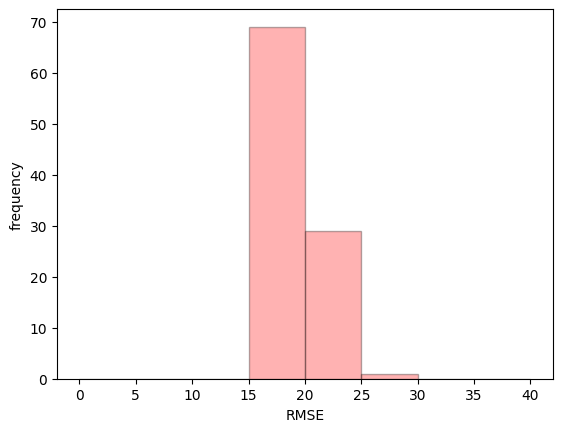

RMSE AVG = 19.876686020394814, RMSE STD = 4.050154125469045
Residual AVG = -1.2392147637194408, Residual STD = 20.24724036412845
stat: 18308.36806089597, p_value: 0.0
Skew: -1.1212108966788639, Kurtosis: 15.979324093084276
one sigma percent: 0.7556692913385826, two sigma percent: 0.9559842519685039, three sigma percent: 0.9881299212598426


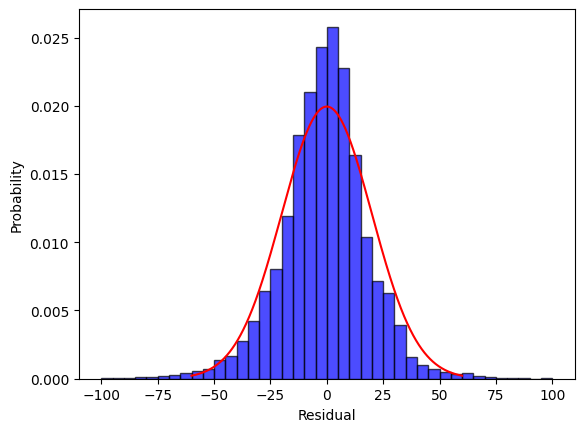

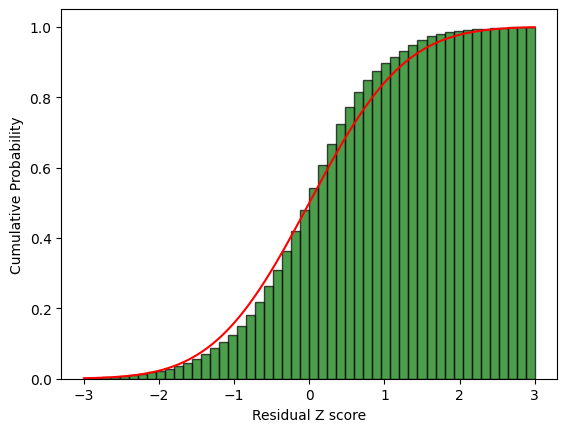

In [23]:
if __name__ == "__main__":
    nodes = 60
    times = 100
    level_config_1 = (1.0, 2.0)
    level_config_2 = (2, 3)
    datasets = handle_datasets(train_split=0.8, show_fig=False)
    # Random int without repetition
    random_list = random.sample(range(0, 2**32 - 1), times)
    all_rmse = []
    all_residual = np.array([])
    for i in range(len(random_list)):
        # option 0: compare with previous price difference, option 1: compare with price going up or down predicitons
        res = train(datasets, nodes=nodes, random_state=random_list[i], show_fig=False, threshold_opt=1, level_config=level_config_1)
        print(f"finish model {i}")
        all_rmse.append(res["RMSE"])
        all_residual = np.append(all_residual, res["residual"])
    plt.clf()
    plt.hist(all_rmse, bins=8, range=(0, 40), facecolor="red", edgecolor="black", alpha=0.3)
    plt.xlabel("RMSE")
    plt.ylabel("frequency")
    plt.show(block=False)
    rmse_avg = np.mean(all_rmse)
    rmse_std = np.std(all_rmse)
    print(f"RMSE AVG = {rmse_avg}, RMSE STD = {rmse_std}")
    res_avg = np.mean(all_residual)
    res_std = np.std(all_residual)
    print(f"Residual AVG = {res_avg}, Residual STD = {res_std}")
    # Normal distribution Test
    test_result = stats.normaltest(all_residual)
    print(f"stat: {test_result.statistic}, p_value: {test_result.pvalue}")
    print(f"Skew: {stats.skew(all_residual)}, Kurtosis: {stats.kurtosis(all_residual)}")
    # check three-sigma rule
    one_sigma = count_items_in_interval(all_residual,res_avg-res_std,res_avg+res_std)
    two_sigma = count_items_in_interval(all_residual,res_avg-2*res_std,res_avg+2*res_std)
    three_sigma = count_items_in_interval(all_residual,res_avg-3*res_std,res_avg+3*res_std)
    print(f"one sigma percent: {one_sigma}, two sigma percent: {two_sigma}, three sigma percent: {three_sigma}")
    # np.histogram 取誤差範圍 range=-200~200, bins=? 分?組
    hist,bins = np.histogram(a=all_residual,bins=10,range=(-200,200),density=False)
    plt.clf()
    # 顯示常態分佈曲線
    mu = 0
    sigma = 20
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color="#FF0000")
    # 取誤差範圍 range=-200~200, bins=80 分80組 每組差5, density=True 回傳機率而非次數
    plt.hist(all_residual, bins=40, range=(-100,100), facecolor="blue", edgecolor="black", alpha=0.7, density=True)
    plt.xlabel("Residual")
    plt.ylabel("Probability")
    plt.show()
    # 顯示z score分佈曲線
    mu = 0
    sigma = 1
    z_residual = stats.zscore(all_residual)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
    plt.plot(x, stats.norm.cdf(x, mu, sigma), color="#FF0000")
    plt.hist(z_residual, bins=50, range=(-3,3), facecolor="#007500", edgecolor="black", alpha=0.7, density=True, cumulative=True)
    plt.xlabel("Residual Z score")
    plt.ylabel("Cumulative Probability")
    plt.show()